# Create the rf feature training dataset VERSION2

ueses v3 of FDD data

corrects +1 SP and TDD data

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
from multigrids import TemporalGrid, MultiGrid, TemporalMultiGrid
from atm.images import raster
import os

data_dir = ('/Users/rwspicer/Desktop/data/V1/')
# os.listdir(data_dir)



fdd = TemporalGrid(os.path.join(data_dir, 'degree-day/freezing/ACP/v3/temporal-grid/ACP_FDD.yml'))
fdd.config['ts_offset'] = 0

tdd = TemporalGrid(os.path.join(data_dir, 'degree-day/thawing/ACP/v2/temporal-grid/ACP-TDD.yml'))
tdd.config['ts_offset'] = 0

# tdd_p1 = TemporalGrid(os.path.join(data_dir, 'degree-day/thawing/ACP/v2/temporal-grid/ACP-TDD.yml'))
# tdd_p1.config['ts_offset'] = 1

ewp = TemporalGrid(
    os.path.join(data_dir, 'precipitation/early-winter/ACP/v2/temporal-grid/ACP_early_winter_precip_mm.yml')
)
ewp.config['ts_offset'] = 0

fwp = TemporalGrid(
    os.path.join(data_dir, 'precipitation/full-winter/ACP/v2/temporal-grid/ACP_full_winter_precip_mm.yml')
)
fwp.config['ts_offset'] = 0

lsp = TemporalGrid(
    os.path.join(data_dir, 'precipitation/late-summer/ACP/v2/temporal-grid/ACP_late_summer_precip_mm.yml')
)
lsp.config['ts_offset'] = 0

sp = TemporalGrid(
    os.path.join(data_dir, 'precipitation/summer/ACP/v2/temporal-grid/ACP_summer_precip_mm.yml')
)
sp.config['ts_offset'] = 0

# sp_p1 = TemporalGrid(
#     os.path.join(data_dir, 'precipitation/summer/ACP/v2/temporal-grid/ACP_summer_precip_mm.yml')
# )
# sp_p1.config['ts_offset'] = 0

# geoloc = MultiGrid(os.path.join('geolocation/geolocation/ACP/v1/multigrid/ACP-geolocation.yml'))
lat, md = raster.load_raster(os.path.join(data_dir, 'geolocation/geolocation/ACP/v1/ACP-geolocation_lat.tif' ))
long, md = raster.load_raster(os.path.join(data_dir, 'geolocation/geolocation/ACP/v1/ACP-geolocation_long.tif' ))
aspect, md = raster.load_raster(os.path.join(data_dir, 'geolocation/aspect/ACP/v1/ACP-ASPECT1000m.tif' ))
slope, md = raster.load_raster(os.path.join(data_dir, 'geolocation/slope/ACP/v1/ACP-SLOPE1000m.tif' ))
elev, md = raster.load_raster(os.path.join(data_dir, 'geolocation/elevation/ACP/v1/ACP-DEM1000m.tif' ))



In [72]:
tdd_p1 = tdd.clone()
tdd_p1.grids[:-1] = tdd.grids[1:] # tdd_p1[0] <- tdd[1], tdd_p1[1] <- tdd[2], and so on
tdd_p1.config['ts_offset'] = 1

sp_p1 = tdd.clone()
sp_p1.grids[:-1] = sp.grids[1:] # same as tdd +1
sp_p1.config['ts_offset'] = 1

In [73]:
np.allclose(tdd[1902], tdd_p1[1901],equal_nan=True)



True

In [93]:
tki = TemporalGrid(os.path.join(data_dir, 
    'thermokarst/initiation-regions/ACP/v4/PDM-5var/with_predisp/multigrid/ACP-TKI-PDM5-with-predisp.yml'))
tki[1901]

memmap([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.]], dtype=float32)

In [111]:
years = fdd.config['real_shape'][0]
rows = fdd.config['real_shape'][1]
cols = fdd.config['real_shape'][2]
grid_names = ['fdd', 'tdd', 'tdd+1', 'ewp', 'fwp', 'sp', 'lsp', 'sp+1', 'lat', 'long','aspect','slope', 'elev' ]
grids = len(grid_names)

trainset = TemporalMultiGrid(rows,cols,grids,years, grid_names = grid_names)
trainset.config['start_timestep'] = 1901

trainset['lat'][:] = lat
trainset['long'][:] = long
trainset['elev'][:] = elev
trainset['slope'][:] = slope
trainset['aspect'][:] = aspect

trainset['fdd'][:] = fdd.grids.reshape((years,rows,cols))[:]


trainset['tdd'][:] = tdd.grids.reshape((years ,rows,cols))[:]
trainset['tdd+1'][:] = tdd_p1.grids.reshape((years,rows,cols))[:]

trainset['ewp'][:] = ewp.grids.reshape((years,rows,cols))[:]
trainset['fwp'][:-1] = fwp.grids.reshape((years-1,rows,cols))[:]

trainset['sp'][:] = sp.grids.reshape((years,rows,cols))[:]
trainset['lsp'][:] = lsp.grids.reshape((years,rows,cols))[:]

trainset['sp+1'][:] = sp_p1.grids.reshape((years ,rows,cols))[:]


trainset.grids[trainset.grids == -9999] = np.nan

mask = np.isnan(trainset[grid_names[0], 2015]) == False
for grid in grid_names[1:]:
    mask = np.logical_and(
        np.isnan(trainset[grid, 2015])== False, mask)
    
trainset.config['mask'] = mask




In [114]:
trainset.config['dataset_name'] = 'ACP Training Data base'
trainset.config['description'] = """ACP Training Data with base features used in intital tests.
With corrected +1 labels, and FDD v3
"""
trainset.config['dataset_version'] = '2.0.0'
trainset.save('/Users/rwspicer/Desktop/data/V1/master-project/training/ACP/v2/baseline/multigrid/ACP-training-base.yml')

In [76]:
np.allclose(trainset['tdd',1902],trainset['tdd+1',1901], equal_nan=True)

True

In [77]:
trainset['tdd',2014]#1454.1384
trainset['tdd',2015]#1575.9824
trainset['tdd+1',2014]#1575.9824
trainset['tdd+1',2015]#1575.9824 ##  here 2015 is a repeat of 2014 which is what I want

memmap([[      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ..., 1575.9824, 1572.1144,
         1571.8606],
        [      nan,       nan,       nan, ..., 1578.4976, 1572.6293,
         1572.341 ],
        [      nan,       nan,       nan, ..., 1570.5713, 1575.1892,
         1575.5209]], dtype=float32)

In [78]:
monthly_precip = TemporalGrid(
    os.path.join(data_dir, 'precipitation/monthly/ACP/v2/temporal-grid/ACP_precip_mm.yml')
)

In [79]:
winter_1901 = monthly_precip.get_grids_at_keys(['1901-10','1901-11','1901-12','1902-01','1902-02','1902-02'])
winter_1901= winter_1901.sum(0)
np.allclose(fwp[1902], trainset['fwp',1902] , equal_nan=True)
fwp[1902]#108.77432#108.77432
trainset['fwp',1902]#108.77432


memmap([[       nan,        nan,        nan, ...,        nan,        nan,
                nan],
        [       nan,        nan,        nan, ...,        nan,        nan,
                nan],
        [       nan,        nan,        nan, ...,        nan,        nan,
                nan],
        ...,
        [       nan,        nan,        nan, ..., 108.77432 , 109.753395,
         109.81946 ],
        [       nan,        nan,        nan, ..., 109.      , 109.93679 ,
         110.      ],
        [       nan,        nan,        nan, ..., 107.09027 , 109.81607 ,
         110.      ]], dtype=float32)

In [81]:
trainset.config['start_timestep'] = 1901
print(np.allclose(trainset['tdd', 1952], trainset['tdd+1',1951], equal_nan=True) )
print(np.allclose(trainset['sp', 1952], trainset['sp+1',1951], equal_nan=True) )

True
True


In [85]:
y=2015
def show(data, title):
    plt.matshow(data)
    plt.title(title)
    plt.colorbar()
    plt.show()
# show(trainset['lat',y], 'lat')
# show(trainset['long',y], 'long')
# show(trainset['elev',y], 'elev')
# show(trainset['slope',y], 'slope')
# show(trainset['aspect',y], 'aspect')

# show(trainset['fdd',y], 'fdd')
# show(trainset['tdd',y], 'tdd')
# show(trainset['tdd+1',y], 'tdd+1')

# show(trainset['ewp',y], 'ewp')
# show(trainset['fwp',y], 'fwp')
# show(trainset['lsp',y], 'lsp')
# show(trainset['sp',y], 'sp')

# show(trainset['sp+1',y], 'sp+1')

# plt.imshow(mask)

In [87]:
def get_as_ml_features(self, mask = None, train_range = None):
    features = [ [] for g in range(self.config['num_grids']) ]
    if mask is None:
        mask = self.config['mask']
    
    if train_range is None:
        train_range = self.get_range()
    
    for ts in train_range:
        for grid, gnum in self.config['grid_name_map'].items():
#             print(grid, '\t',gnum, '\t',self[grid, ts][mask].shape, '\t', self[grid, ts][mask])

            features[gnum] += list(self[grid, ts][mask])

        
    return np.array(features)
# trainset.get_as_ml_features(None, None, [1902,1950])
features = get_as_ml_features(trainset, trainset.config['mask'], range(1902, 2015))
features.shape

(13, 34011192)

array([[-5.2608032e+03, -5.2607778e+03, -5.2607778e+03, ...,
        -2.6767642e+03, -2.5715652e+03, -2.5643269e+03],
       [ 3.1333881e+02,  3.1336197e+02,  3.1336197e+02, ...,
         1.5644883e+03,  1.5701044e+03,  1.5705713e+03],
       [ 3.1545200e+02,  3.1547095e+02,  3.1547095e+02, ...,
         1.5644883e+03,  1.5701044e+03,  1.5705713e+03],
       ...,
       [ 1.3500000e+02,  2.2500000e+02,  3.1500000e+02, ...,
         3.3291879e+02,  3.1614008e+02,  2.8843494e+02],
       [ 2.0257115e-02,  2.0257115e-02,  1.0128559e-02, ...,
         1.7771289e+00,  2.0353868e+00,  4.0765974e-01],
       [ 2.4600000e+02,  2.4500000e+02,  2.4600000e+02, ...,
         1.9400000e+02,  2.5100000e+02,  2.4200000e+02]], dtype=float32)

In [94]:
labels = tki.get_as_ml_features(None, trainset.config['mask'], range(1902, 2015))

In [95]:
labels.shape

(34011192,)

In [96]:
def get_data_subsample(features, labels, percent=.50):
    """return a random subsample of data set
    
    using a “discrete uniform” distribution
    
    Parameters
    ----------
    features: np.array [n_features, n_samples]
        the features array
    labels: np.array [n_samples]
    percent: float [0, 1]
        percent of data to keep
        
    Returns 
    -------
    np.array[n_features, n_samples * percent]
        randomly subsampled feature array 
    np.array[n_features, n_samples * percent]
        randomly subsampled lable array using same 
        index as sampling feature array
    """
    _max = features.shape[1]
    keep = int(_max * percent)
    idx = np.random.randint(_max, size=keep)
    return features.T[idx].T, labels[idx]

flabels = ['' for g in range(trainset.config['num_grids']) ]
for grid, gnum in trainset.config['grid_name_map'].items():
    flabels[gnum] = grid
# features
# labels

In [97]:
ss_f, ss_l = get_data_subsample(features, labels)

In [98]:
features.shape[1], labels.shape[0]

(34011192, 34011192)

In [100]:
ss_f.shape, ss_l.shape

((13, 17005596), (17005596,))

In [29]:
# ss_sample = MultiGrid(1, 17156088, 14, grid_names=grid_names+['tki'])
# for idx, grid in enumerate(grid_names):
#     ss_sample[grid][:] = ss_f[idx]
# #     print(idx,grid)

# ss_sample['tki'] = ss_l
#ss_sample.save('rfm_e10_rs42_mln1000/training_data.yml')

In [101]:
from pandas import read_csv, get_dummies, DataFrame
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import datetime

In [102]:
rf = RandomForestRegressor(n_estimators = 10, random_state = 42, max_leaf_nodes=1000, verbose=2, n_jobs=4)
rf.fit(ss_f.T, ss_l)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 10
building tree 2 of 10
building tree 3 of 10building tree 4 of 10

building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed: 15.9min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=1000,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
           oob_score=False, random_state=42, verbose=2, warm_start=False)

In [103]:
rf.feature_importances_

array([1.09361207e-01, 8.28718112e-02, 7.39295132e-02, 1.22942203e-01,
       8.98326273e-02, 1.12155822e-01, 7.59209364e-02, 1.38391335e-01,
       1.04461598e-01, 9.01130028e-02, 0.00000000e+00, 1.99439079e-05,
       0.00000000e+00])

In [104]:
fid = {}
for i, v in enumerate(flabels):
    fid[v] = rf.feature_importances_[i]*100

In [105]:
fid

{'fdd': 10.936120703315137,
 'tdd': 8.287181118803373,
 'tdd+1': 7.392951324210638,
 'ewp': 12.294220339755443,
 'fwp': 8.98326273444179,
 'sp': 11.215582197235733,
 'lsp': 7.592093637521017,
 'sp+1': 13.83913346990065,
 'lat': 10.446159801843471,
 'long': 9.011300282187058,
 'aspect': 0.0,
 'slope': 0.001994390785697014,
 'elev': 0.0}

In [109]:
ty = 2004

pf = trainset[ty]
test_f = []
for f in pf:
#     print(f[mask])
    test_f.append(list(f[mask]))
# rf.predicttrainset
test_f = np.array(test_f)
test_r = rf.predict(test_f.T)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


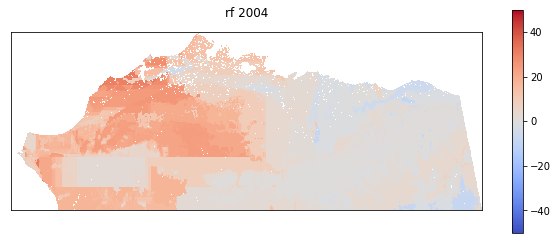

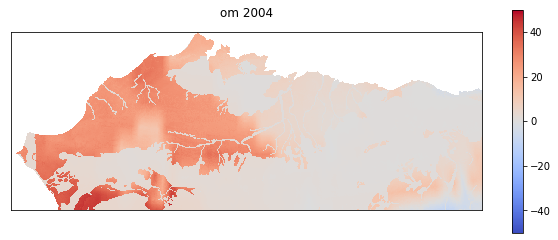

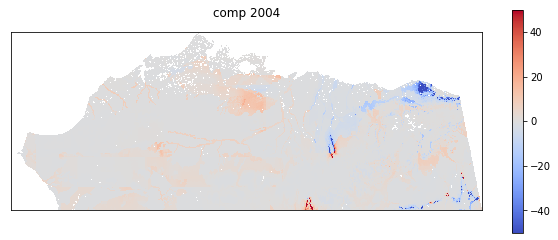

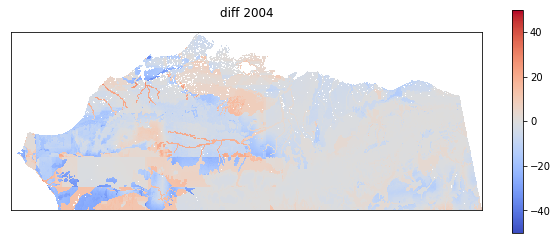

In [110]:
test_map = np.zeros([415,1096]) - np.nan
test_map[mask]= test_r
def show2 (data, title, save =False):
    plt.matshow(data, vmin=-50, vmax=50, cmap='coolwarm')
    plt.title(title)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    if save:
        plt.savefig( title + '.png')

# show2(test_map, 'rf '+str(ty))
# show2(tki[ty], 'om '+str(ty))
# show2((test_map - tki[ty])/ np.abs(tki[ty]), 'comp ' +str(ty))
show2(test_map, 'rf '+str(ty), save=True)
show2(tki[ty], 'om '+str(ty),save=True)
show2((test_map - tki[ty])/ np.abs(tki[ty]), 'comp ' +str(ty),save=True)
show2((test_map - tki[ty]), 'diff ' +str(ty),save=True)



In [99]:
import pickle
def save_rf_model(model, filename):
    with open(filename, 'wb') as f:
        pickle.dump( model,f)

In [101]:
save_rf_model(rf, "rfm_e10_rs42_mln1000.pickle")

In [104]:
trainset.save('rf_traing_set_v1.yml')

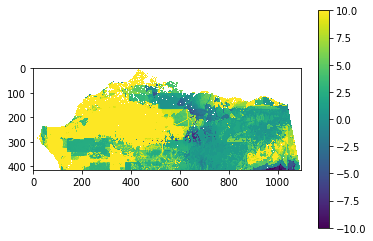

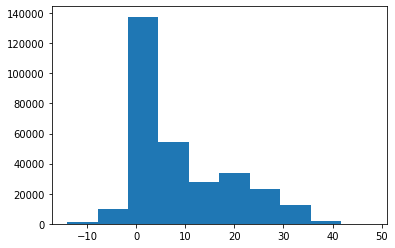

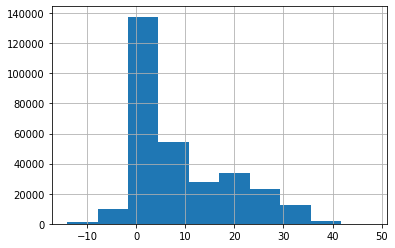

In [163]:
plt.imshow((test_map - tki[ty]), vmin=-10,vmax=10)
plt.colorbar()
plt.show()

diff = (test_map - tki[ty])

plt.hist(diff[mask])
plt.show()
from pandas import Series

ds = Series(diff[mask])
ds.hist()
plt.savefig('histogram' + str(ty) + '.png')

# diff[mask].mean(), diff[mask].std(), diff[mask].min(),diff[mask].max() 